In [14]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [15]:
import numpy as np
import pandas as pd

In [16]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [17]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [18]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [19]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [20]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [21]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [22]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [23]:
#inspect tables
inspector = inspect(engine)
inspector.get_table_names() 

engine.execute('SELECT * FROM Measurement ORDER BY date DESC LIMIT 5').fetchall()

[(2724, 'USC00519397', '2017-08-23', 0.0, 81.0),
 (7635, 'USC00514830', '2017-08-23', 0.0, 82.0),
 (12187, 'USC00519523', '2017-08-23', 0.08, 82.0),
 (19550, 'USC00516128', '2017-08-23', 0.45, 76.0),
 (2723, 'USC00519397', '2017-08-22', 0.0, 82.0)]

# Exploratory Climate Analysis

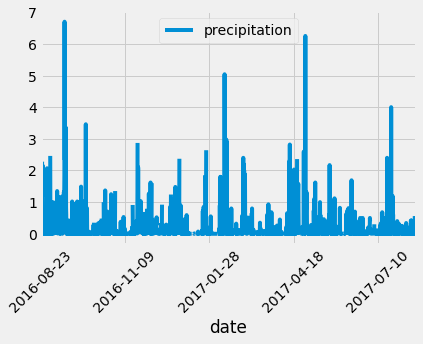

In [24]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
year_pre = dt.date(2017,8,23)-dt.timedelta(days=365)
year_pre
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=year_pre).all()
results
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns= ["date","precipitation"])
df.set_index(df['date'],inplace=True)
# Sort the dataframe by date
df= df.sort_index()
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=45);

![precipitation](Images/precipitation.png)

In [25]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [26]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

                                            

[(9)]

In [27]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

              

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
    .filter(Measurement.station=='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

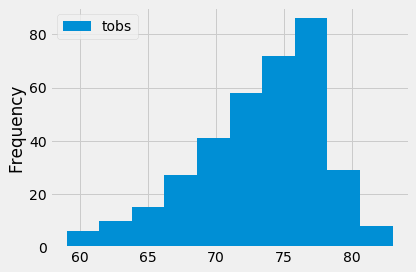

In [29]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = session.query(Measurement.tobs).filter(Measurement.date>=year_pre)\
    .filter(Measurement.station=='USC00519281').all()
df = pd.DataFrame(temp_results)
df.plot.hist(bins=10)
plt.tight_layout();

![precipitation](Images/station-histogram.png)

In [30]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
result = calc_temps(year_pre,dt.date(2017,8,23))
result

[(58.0, 74.59058295964125, 87.0)]

Text(0.5, 1.0, 'Trip Avg Temperature')

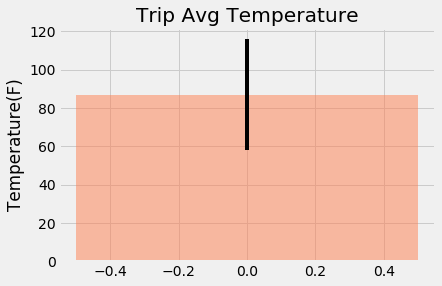

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr) 
tmin = result[0][0]
tavg = result[0][1]
tmax = result[0][2]
yerr = tmax-tmin

bar = plt.bar(0, tmax, yerr=yerr, alpha=0.5,width=1, color='coral', align="center")
plt.ylabel("Temperature(F)")
plt.title("Trip Avg Temperature")




In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.


session.query(Measurement.station, func.sum(Measurement.prcp))\
    .filter(Measurement.date>=year_pre)\
    .filter(Measurement.date<=dt.date(2017,8,23))\
    .group_by(Measurement.station)\
    .order_by(func.sum(Measurement.prcp).desc()).all() 

[('USC00516128', 147.81000000000006),
 ('USC00519281', 70.03000000000003),
 ('USC00513117', 48.510000000000026),
 ('USC00519523', 38.01),
 ('USC00514830', 33.239999999999995),
 ('USC00519397', 16.089999999999986),
 ('USC00517948', 4.59)]

In [39]:
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station,Station.name,func.sum(Measurement.prcp),Station.latitude,Station.longitude,Station.elevation]
results = session.query(*sel).filter(Measurement.station==Station.station)\
                       .filter(Measurement.date>=year_pre).filter(Measurement.date<=dt.date(2017,8,23))\
                       .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
for x in results:
    print(x)

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 147.81000000000006, 21.3331, -157.8025, 152.4)
('USC00519281', 'WAIHEE 837.5, HI US', 70.03000000000003, 21.45167, -157.84888999999998, 32.9)
('USC00513117', 'KANEOHE 838.1, HI US', 48.510000000000026, 21.4234, -157.8015, 14.6)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 38.01, 21.33556, -157.71139, 19.5)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 33.239999999999995, 21.5213, -157.8374, 7.0)
('USC00519397', 'WAIKIKI 717.2, HI US', 16.089999999999986, 21.2716, -157.8168, 3.0)
('USC00517948', 'PEARL CITY, HI US', 4.59, 21.3934, -157.9751, 11.9)


## Optional Challenge Assignment

In [40]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [41]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start = '2017-01-01'
end = '2018-01-01'
# Use the start and end date to create a range of dates
dates = pd.date_range(start, end, freq='D')
# Stip off the year and save a list of %m-%d strings
month_day = dates.strftime('%m-%d')
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in month_day:
    normals.append(*daily_normals(date))
    
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0),
 (57.0, 67.16071428571429, 75.0),
 (58.0, 67.9298245614035, 78.0),
 (62.0, 69.74137931034483, 77.0),
 (57.0, 67.3103448275862, 78.0),
 (57.0, 67.4074074074074, 81.0),
 (57.0, 67.25454545454545, 77.0),
 (58.0, 69.52631578947368, 77.0),
 (56.0, 69.31372549019608, 78.0),
 (54.0, 68.62962962962963, 80.0),
 (61.0, 69.07407407407408, 76.0),
 (57.0, 68.63157894736842, 77.0),
 (60.0, 68.26315789473684, 78.0),
 (61.0, 68.86666666666666, 78.0),
 (61.0, 70.14545454545454, 76.0),
 (60.0, 69.26415094339623, 76.0),
 (57.0, 69.50909090909092, 79.0),
 (58.0, 68.76271186440678, 78.0),
 (61.0, 67.94915254237289, 75.0),
 (61.0, 70.58620689655173, 77.0),
 (59.0, 68.56896551724138, 75.0),
 (62.0, 69.03703703703704, 77.0),
 (64.0, 69.14, 76.0),
 (60.0, 67.12962962962963, 77.0),
 (60.0, 6

In [42]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df['date'] = dates
df.set_index(['date'],inplace=True)
df.head()

,tmin,tavg,tmax
date,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0


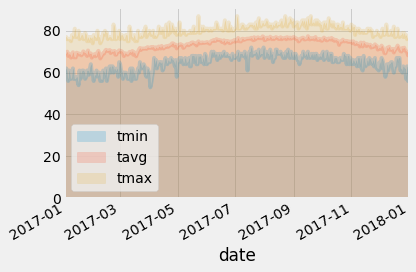

In [43]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()